<a href="https://colab.research.google.com/github/MehakArora/ImageInpainting/blob/main/Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import os
import cv2
print(cv2.__version__)
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# example of defining a composite model for training the generator model
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D
from keras.utils import generic_utils
from skimage.metrics import structural_similarity as SSIM


from keras.utils.vis_utils import plot_model

2.8.0
4.1.2


In [3]:
## Reference: https://github.com/MathiasGruber/PConv-Keras/blob/master/libs/pconv_layer.py
from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D


class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):        
        """Adapted from original _Conv() layer of Keras        
        param input_shape: list of dimensions for [img, mask]
        """
        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
            
        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')
            
        self.input_dim = input_shape[0][channel_axis]
        
        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Calculate padding size to achieve zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
        )

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        We will be using the Keras conv2d method, and essentially we have
        to do here is multiply the mask with the input X, before we apply the
        convolutions. For the mask itself, we apply convolutions with all weights
        set to 1.
        Subsequently, we clip mask values to between 0 and 1
        ''' 

        # Both image and mask must be supplied
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )        

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Clip output to be between 0 and 1
        mask_output = K.clip(mask_output, 0, 1)

        # Remove ratio values where there are holes
        mask_ratio = mask_ratio * mask_output

        # Normalize iamge output
        img_output = img_output * mask_ratio

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)
        
        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)
            
        return [img_output, mask_output]
    
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]

## Reference: https://github.com/keras-team/keras/blob/7a39b6c62d43c25472b2c2476bd2a8983ae4f682/keras/utils/conv_utils.py#L85
def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    """Determines output length of a convolution given input length.
    # Arguments
        input_length: integer.
        filter_size: integer.
        padding: one of `"same"`, `"valid"`, `"full"`.
        stride: integer.
        dilation: dilation rate, integer.
    # Returns
        The output length (integer).
    """
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = (filter_size - 1) * dilation + 1
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride

# Intel 

In [4]:
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "./drive/MyDrive/archive(1).zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

"Getting File Names"

#Train Data
train_path = './seg_train/seg_train/'
train_folders = os.listdir(train_path)
train_files = []

for folder in train_folders:
    files_f = os.listdir(train_path + folder + '/')
    for file in files_f:
        train_files.append(train_path + folder + '/' + file)
        
#Val Data
val_path = './seg_test/seg_test/'
val_folders = os.listdir(val_path)
val_files = []

for folder in val_folders:
    files_f = os.listdir(val_path + folder + '/')
    for file in files_f:
        val_files.append(val_path + folder + '/' + file)
  
#Testing Data
pred_path = './seg_pred/seg_pred/'
pred_files = []


for file in os.listdir(pred_path):
    pred_files.append(pred_path + file)

Streaming output truncated to the last 5000 lines.
seg_train/seg_train/mountain/7539.jpg          2019-10-18 05:52:02        16948
seg_train/seg_train/mountain/7551.jpg          2019-10-18 05:52:02         8318
seg_train/seg_train/mountain/7560.jpg          2019-10-18 05:52:02         8029
seg_train/seg_train/mountain/7565.jpg          2019-10-18 05:52:02        10892
seg_train/seg_train/mountain/7578.jpg          2019-10-18 05:52:02        11674
seg_train/seg_train/mountain/7581.jpg          2019-10-18 05:52:02        14910
seg_train/seg_train/mountain/7586.jpg          2019-10-18 05:52:02         6908
seg_train/seg_train/mountain/7647.jpg          2019-10-18 05:52:02        20167
seg_train/seg_train/mountain/7652.jpg          2019-10-18 05:52:02        11952
seg_train/seg_train/mountain/7654.jpg          2019-10-18 05:52:02        11998
seg_train/seg_train/mountain/7662.jpg          2019-10-18 05:52:02         7367
seg_train/seg_train/mountain/767.jpg           2019-10-18 05:52:02   

In [5]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class ImgInpaintingDataset(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, files, batch_size=32, dim=(128, 128), n_channels = 3, shuffle=True):
      'Initialization'

      self.files = files
      self.batch_size = batch_size 
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.files) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.files))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image
    m_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Mask

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = cv2.imread(self.files[idx]).copy()
      image_copy = cv2.resize(image_copy, (128,128), interpolation = cv2.INTER_CUBIC)
  
      ## Get mask associated to that image
      masked_image, mask = self.__createMask(image_copy)
      
      X_batch[i,] = masked_image/255.
      y_batch[i] = image_copy/255.
      m_batch[i] = mask/255.
      
    return X_batch, y_batch, m_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    
    shape = img.shape
    mask = np.full(img.shape, 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, shape[0]), np.random.randint(1, shape[1])
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, shape[0]), np.random.randint(1, shape[1])
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 5)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image, mask

In [6]:
class InpaintingModel:

  def define_gan(self, g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
      if not isinstance(layer, BatchNormalization):
        layer.trainable = False
    
    input_image = Input(shape=image_shape)
    input_mask = Input(shape=image_shape)

    # connect the source image to the generator input
    gen_out = g_model([input_image, input_mask])

    # connect the source input and generator output to the discriminator input
    dis_out = d_model([input_image, gen_out])

    # src image as input, generated image and classification output
    model = Model([input_image, input_mask], [dis_out, gen_out])
    
    return model

  def discriminator(self, input_size=(128,128,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    masked_image = Input(shape=input_size)
    # target image input
    inpainted_image = Input(shape=input_size)
    # concatenate images channel-wise
    merged = Concatenate()([masked_image, inpainted_image])
    # C64
    conv1 = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    relu1 = LeakyReLU(alpha=0.2)(conv1)
    # C128
    conv2 = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(relu1)
    bn2 = BatchNormalization()(conv2)
    relu2 = LeakyReLU(alpha=0.2)(bn2)
    # C256
    conv3 = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(relu2)
    bn3 = BatchNormalization()(conv3)
    relu3 = LeakyReLU(alpha=0.2)(bn3)
    # C512
    conv4 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(relu3)
    bn4 = BatchNormalization()(conv4)
    relu4 = LeakyReLU(alpha=0.2)(bn4)
    # second last output layer
    conv5 = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(relu4)
    bn5 = BatchNormalization()(conv5)
    relu5 = LeakyReLU(alpha=0.2)(bn5)
    # patch output
    convout = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(relu5)
    patch_out = Activation('sigmoid')(convout)
    # define model
    model = Model([masked_image, inpainted_image], patch_out)
    
    return model

  def generator(self, input_size=(128,128,3), training = True):
    input_image = Input(input_size)
    input_mask = Input(input_size, name='encoder_input')
  
    conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'], training, batchnorm = False)
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'], training)
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'], training)
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'], training)

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'], training)
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'], training)
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'], training)
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'], training)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return Model(inputs=[input_image, input_mask], outputs=[outputs])
    
  def __encoder_layer(self, filters, in_layer, in_mask, names, training, batchnorm = True):
    conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    if batchnorm:
      conv2 = BatchNormalization()(conv2, training=training)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names, training):
    up_img = UpSampling2D(size=(2,2))(in_img)
    up_mask = UpSampling2D(size=(2,2))(in_mask)
    concat_img = Concatenate(axis=3)([share_img, up_img])
    concat_mask = Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    conv2 = BatchNormalization()(conv2, training = training)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

In [7]:
def metric_psnr(y_true, y_pred):

  val = tf.image.psnr(y_true, y_pred, 1)

  return val

def metric_ssim(y_true, y_pred):

  
  if(y_true.shape[1] == 8):
    val = 0
  else:
    val = tf.image.ssim(y_true, y_pred, 1)

  return val

def dice_coef(y_true, y_pred):
   y_true_f = keras.backend.flatten(y_true)
   y_pred_f = keras.backend.flatten(y_pred)
   intersection = keras.backend.sum(y_true_f * y_pred_f)
   return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [37]:
keras.backend.clear_session()
img_shape = (128,128,3)
discriminator = InpaintingModel().discriminator(img_shape)
generator = InpaintingModel().generator(img_shape)
gan_model = InpaintingModel().define_gan(generator, discriminator, img_shape)
gan_model.summary()

epoch = 20

gan_model.load_weights("./drive/MyDrive/gan_epoch" + str(epoch))
#keras.utils.plot_model(model, show_shapes=True, dpi=60, to_file='model_v2.png')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 128, 128, 3)  1719971     ['input_4[0][0]',                
                                                                  'input_5[0][0]']          

In [10]:
traingen = ImgInpaintingDataset(train_files)
valgen = ImgInpaintingDataset(val_files)
testgen = ImgInpaintingDataset(pred_files, shuffle = False)

(32, 128, 128, 3)


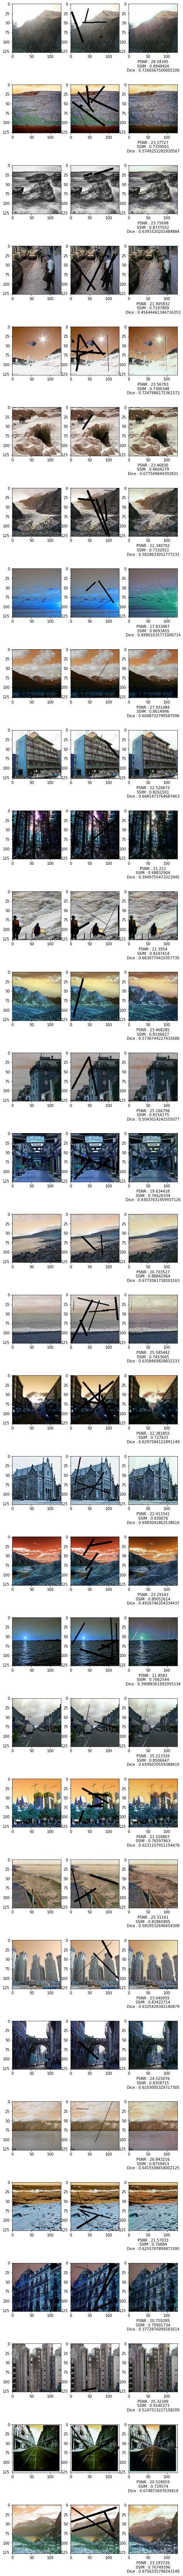

In [39]:
idx = 10
tf.compat.v1.enable_eager_execution()

val_masked, val_og, val_masks = valgen[idx]

d, out = gan_model.predict([val_masked, val_masks])
print(out.shape)

rows = 32
fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(8, 4*rows))

for i in range(rows):
  
  psnr = metric_psnr(val_og[i], out[i].astype('float64'))
  ssim = metric_ssim(val_og[i],  out[i].astype('float64'))
  dice = dice_coef(val_og[i], out[i].astype('float64'))
  axs[i][0].imshow(val_og[i])                                              # Ground truth
  axs[i][1].imshow(val_masked[i])                                              # Masked image
  axs[i][2].imshow(out[i])
  axs[i][2].set_xlabel("PSNR : " + str(psnr.numpy()) + "\nSSIM : " + str(ssim.numpy()) + "\nDice : " + str(dice.numpy()))

In [33]:
dice.numpy()

0.7336383540286283

(32, 128, 128, 3)